In [1]:
    import tensorflow as tf
    from tensorflow import keras

    print(tf.__version__)
    print(keras.__version__)

2025-07-11 19:47:54.482947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 19:47:54.513831: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 19:47:54.800651: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 19:47:55.096125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752281275.318743    1174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752281275.39

2.18.0
3.7.0


In [ ]:
To do:
Implement test set
augment data
potentially try to increase complexity of data
commenting

In [26]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
# Was checking if path was correct need to run cell before first
print(os.path.exists(civilian_folder))  


True


In [18]:
#Have to use /mnt/c/ beacuse i am working through ubuntu
civilian_folder = '/mnt/c/Users/smith/Downloads/Vehicle Classification.v2i.folder/train/car'
target_folder = 'Police_Car/data/civilian'

os.makedirs(target_folder, exist_ok=True)

# List all images
all_images = [f for f in os.listdir(civilian_folder) if f.lower().endswith(('.jpg', '.png'))]

# Randomly sample n images
n=1000
sampled_images = random.sample(all_images, n)

# Copy to target folder
for img_name in sampled_images:
    shutil.copy(os.path.join(civilian_folder, img_name), os.path.join(target_folder, img_name))

In [19]:
police_source = '/mnt/c/Users/smith/Downloads/police_cars.v1i.folder/train'
police_target = 'Police_Car/data/police'

os.makedirs(police_target, exist_ok=True)

for img_name in os.listdir(police_source):
    if img_name.lower().endswith(('.jpg', '.png')):
        shutil.copy(os.path.join(police_source, img_name), os.path.join(police_target, img_name))





In [23]:
data_dir = 'Police_Car/data' 

#splitting data set
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

#basic augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load training images
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load validation images
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1642 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [27]:
# Load the ResNet50 model, without the top classification layer, and with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to start with
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Trying out early stopping because why not, will customize later
early_stop = EarlyStopping(
    monitor='val_loss',      # what to monitor
    patience=3,              # stop after 3 epochs of no improvement
    restore_best_weights=True  # revert to best weights
)

# Train the model after small bit of optimization, will customize more later
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop] 
)



Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9549 - loss: 0.2899 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 9.0077e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 8.2150e-04 - val_accuracy: 1.0000 - val_loss: 6.1159e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 1.0000 - loss: 5.8329e-04 - val_accuracy: 1.0000 - val_loss: 4.5342e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 1.0000 - loss: 4.0038e-04 - val_accuracy: 1.0000 - val_loss: 2.3486e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 1.0000 - loss: 2.0718e-04 - 

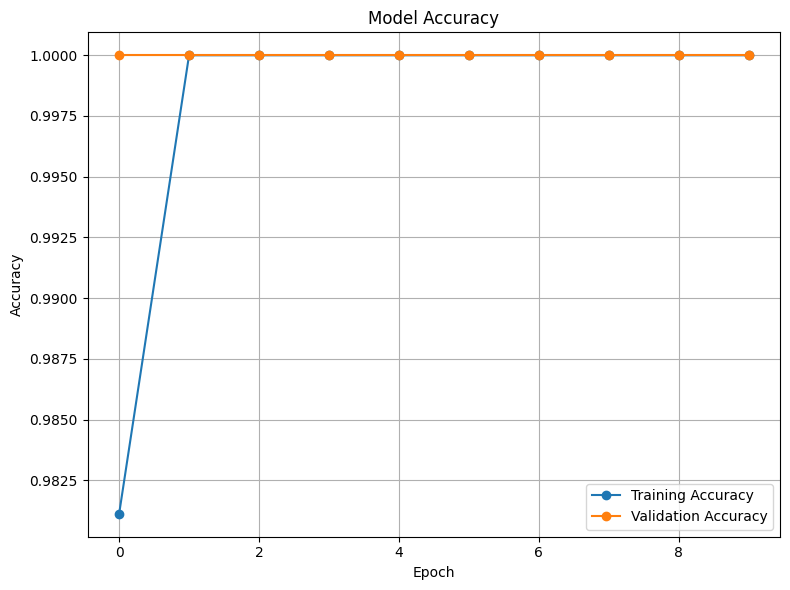

In [22]:

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#When using 400 civilian car images, the accuracy and validation was 100% before augmentation
#When using 1000 civilian car images, the accuracy and validation was 100% before augmentation after 1 epoch
